<a href="https://colab.research.google.com/github/chickfilaman51/SAM2-VideoTracking/blob/main/Krish_sam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Videos with Segment Anything 2 (SAM2)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything-2)

Segment Anything Model 2 (SAM 2) is a foundation model designed to address promptable visual segmentation in both images and videos. The model extends its functionality to video by treating images as single-frame videos. Its design, a simple transformer architecture with streaming memory, enables real-time video processing. A model-in-the-loop data engine, which enhances the model and data through user interaction, was built to collect the SA-V dataset, the largest video segmentation dataset to date. SAM 2, trained on this extensive dataset, delivers robust performance across diverse tasks and visual domains.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-2-paper.jpg)

This notebook is an extension of the official [notebook](https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb) prepared by Meta AI.

## Complementary materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-sam-2.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-segment-anything-2)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model 2 (SAM2).

[![SAM2 blogpost](https://media.roboflow.com/notebooks/examples/blog-what-is-sam-2.png)](https://blog.roboflow.com/what-is-segment-anything-2)

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi
#testing comments in connecting

Fri Aug  2 17:52:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)


HOME: /content


### Install SAM2 and dependencies

In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 306 (delta 14), reused 11 (delta 11), pack-reused 273
Receiving objects: 100% (306/306), 42.93 MiB | 22.89 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 235.2 kB/s eta 0:00:00
  Building edit

In [4]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.6 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Imports

In [6]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [7]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

## Preprocess video

### Download video and split it into frames

**NOTE:** SAM2 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk.

In [9]:
HOME = '/content'
SCALE_FACTOR = 0.5
SOURCE_VIDEO = '/content/mouseVidHide.mov'
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)
cap = cv2.VideoCapture(SOURCE_VIDEO)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=0, end=total_frames) # change
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

SOURCE_IMAGE = SOURCE_FRAMES / "00001.jpeg"
TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [10]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 254/254 [00:08<00:00, 31.05it/s]


**NOTE:** If you have run any previous tracking using this inference_state, please reset it first via reset_state. (The cell below is just for illustration; it's not needed to call reset_state here as this inference_state is just freshly initialized above.)

In [11]:
sam2_model.reset_state(inference_state)

### Prompting with points

In [12]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** To get started, let's try to segment the ball. Execute cell below and use your mouse to **draw point** on the image 👇

In [13]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(SOURCE_IMAGE)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [14]:
widget.bboxes

[{'x': 289, 'y': 158, 'width': 0, 'height': 0, 'label': ''}]

In [15]:
default_box = [{'x': 224, 'y': 171, 'width': 0, 'height': 0, 'label': ''}]

boxes = widget.bboxes if widget.bboxes else default_box
points = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
], dtype=np.float32)
labels = np.ones(len(points))

**NOTE:** Here we make a positive click at `(x, y) = (713, 306)` with label `1`, by sending their coordinates and labels into the add_new_points API. Label `1` indicates a positive click (to add a region) while label `0` indicates a negative click (to remove a region).

### Single frame inference

In [16]:
FRAME_IDX = 0
OBJECT_ID = 1

_, object_ids, mask_logits = sam2_model.add_new_points(
    inference_state=inference_state,
    frame_idx=FRAME_IDX,
    obj_id=OBJECT_ID,
    points=points,
    labels=labels,
)

masks = (mask_logits[0] > 0.0).cpu().numpy()

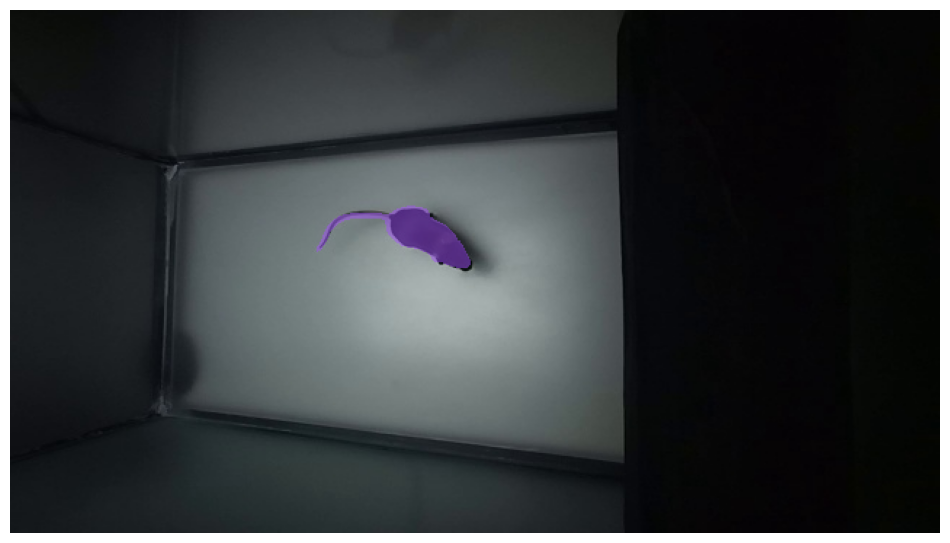

In [17]:
image_bgr = cv2.imread(SOURCE_IMAGE)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_image(segmented_image)

### Video inference

**NOTE:** To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [29]:
import cv2
import numpy as np
from pathlib import Path

# Parameters for drawing the bounding box
TOP_LEFT = (117, 115)
TOP_RIGHT = (415, 87)
BOTTOM_LEFT = (107, 280)
BOTTOM_RIGHT = (423, 320)

MIN_MOUSE_AREA = 3000  # Minimum area for the bounding box of the mouse
MAX_MOUSE_AREA = 14000  # Maximum area for the bounding box of the mouse

def draw_bounding_box_and_lines(frame):
    """Draws a bounding box and lines for the big box around the specified coordinates on the frame."""
    points = np.array([TOP_LEFT, TOP_RIGHT, BOTTOM_RIGHT, BOTTOM_LEFT], np.int32)
    points = points.reshape((-1, 1, 2))
    cv2.polylines(frame, [points], isClosed=True, color=(0, 255, 0), thickness=2)

def filter_detections(detections):
    """Filter detections to keep only those that match the expected size and position of the mouse."""
    filtered_detections = []

    for bbox in detections.xyxy:

        x_min, y_min, x_max, y_max = bbox
        area = (x_max - x_min) * (y_max - y_min)
        if MIN_MOUSE_AREA <= area <= MAX_MOUSE_AREA:
            filtered_detections.append(bbox)
    return filtered_detections

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)
coordinates = []

frame_paths = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = frame_paths[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits[0] > 0.0).cpu().numpy()

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks.astype(bool)
        )

        filtered_detections = filter_detections(detections)

        if filtered_detections:
            coordinates.append(filtered_detections[0])
        else:
            # Append a placeholder coordinate with the same shape as the other coordinates
            coordinates.append([0, 0, 0, 0])

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)
        draw_bounding_box_and_lines(annotated_frame)
        sink.write_frame(annotated_frame)

# Print coordinates for verification
for coord in coordinates:
    print(coord)


propagate in video:   0%|          | 0/254 [00:00<?, ?it/s]

Frame 0: Detected objects:
[211 135 316 177]


propagate in video:   1%|          | 2/254 [00:01<02:06,  1.99it/s]

Frame 1: Detected objects:
[213 137 318 180]


propagate in video:   1%|          | 3/254 [00:01<02:51,  1.46it/s]

Frame 2: Detected objects:
[212 137 319 180]


propagate in video:   2%|▏         | 4/254 [00:02<03:18,  1.26it/s]

Frame 3: Detected objects:
[213 134 318 180]


propagate in video:   2%|▏         | 5/254 [00:03<03:35,  1.15it/s]

Frame 4: Detected objects:
[212 133 315 180]


propagate in video:   2%|▏         | 6/254 [00:04<03:49,  1.08it/s]

Frame 5: Detected objects:
[212 133 315 181]


propagate in video:   3%|▎         | 7/254 [00:06<04:00,  1.03it/s]

Frame 6: Detected objects:
[213 132 314 183]


propagate in video:   3%|▎         | 8/254 [00:07<04:10,  1.02s/it]

Frame 7: Detected objects:
[215 131 315 187]


propagate in video:   4%|▎         | 9/254 [00:08<04:16,  1.05s/it]

Frame 8: Detected objects:
[217 130 318 188]


propagate in video:   4%|▍         | 10/254 [00:09<04:20,  1.07s/it]

Frame 9: Detected objects:
[218 128 320 191]


propagate in video:   4%|▍         | 11/254 [00:10<04:23,  1.08s/it]

Frame 10: Detected objects:
[220 127 323 195]


propagate in video:   5%|▍         | 12/254 [00:11<04:25,  1.10s/it]

Frame 11: Detected objects:
[221 130 325 200]


propagate in video:   5%|▌         | 13/254 [00:12<04:26,  1.11s/it]

Frame 12: Detected objects:
[224 137 328 206]


propagate in video:   6%|▌         | 14/254 [00:13<04:26,  1.11s/it]

Frame 13: Detected objects:
[224 143 330 212]


propagate in video:   6%|▌         | 15/254 [00:15<04:26,  1.12s/it]

Frame 14: Detected objects:
[225 144 333 219]


propagate in video:   6%|▋         | 16/254 [00:16<04:27,  1.12s/it]

Frame 15: Detected objects:
[233 140 336 223]


propagate in video:   7%|▋         | 17/254 [00:17<04:27,  1.13s/it]

Frame 16: Detected objects:
[244 136 338 227]


propagate in video:   7%|▋         | 18/254 [00:18<04:27,  1.13s/it]

Frame 17: Detected objects:
[248 137 340 231]


propagate in video:   7%|▋         | 19/254 [00:19<04:26,  1.13s/it]

Frame 18: Detected objects:
[250 139 343 234]


propagate in video:   8%|▊         | 20/254 [00:20<04:25,  1.14s/it]

Frame 19: Detected objects:
[248 146 342 237]


propagate in video:   8%|▊         | 21/254 [00:21<04:25,  1.14s/it]

Frame 20: Detected objects:
[247 151 342 240]


propagate in video:   9%|▊         | 22/254 [00:23<04:24,  1.14s/it]

Frame 21: Detected objects:
[247 155 342 241]


propagate in video:   9%|▉         | 23/254 [00:24<04:23,  1.14s/it]

Frame 22: Detected objects:
[248 156 342 241]


propagate in video:   9%|▉         | 24/254 [00:25<04:22,  1.14s/it]

Frame 23: Detected objects:
[250 155 342 241]


propagate in video:  10%|▉         | 25/254 [00:26<04:22,  1.15s/it]

Frame 24: Detected objects:
[251 155 342 240]


propagate in video:  10%|█         | 26/254 [00:27<04:21,  1.15s/it]

Frame 25: Detected objects:
[253 154 342 236]


propagate in video:  11%|█         | 27/254 [00:28<04:20,  1.15s/it]

Frame 26: Detected objects:
[253 155 342 232]


propagate in video:  11%|█         | 28/254 [00:29<04:20,  1.15s/it]

Frame 27: Detected objects:
[250 155 342 230]


propagate in video:  11%|█▏        | 29/254 [00:31<04:20,  1.16s/it]

Frame 28: Detected objects:
[250 156 342 228]


propagate in video:  12%|█▏        | 30/254 [00:32<04:19,  1.16s/it]

Frame 29: Detected objects:
[250 158 343 224]


propagate in video:  12%|█▏        | 31/254 [00:33<04:18,  1.16s/it]

Frame 30: Detected objects:
[250 157 344 222]


propagate in video:  13%|█▎        | 32/254 [00:34<04:17,  1.16s/it]

Frame 31: Detected objects:
[251 155 346 223]


propagate in video:  13%|█▎        | 33/254 [00:35<04:16,  1.16s/it]

Frame 32: Detected objects:
[252 154 349 221]


propagate in video:  13%|█▎        | 34/254 [00:36<04:16,  1.16s/it]

Frame 33: Detected objects:
[252 156 352 221]


propagate in video:  14%|█▍        | 35/254 [00:38<04:15,  1.17s/it]

Frame 34: Detected objects:
[253 156 355 223]


propagate in video:  14%|█▍        | 36/254 [00:39<04:14,  1.17s/it]

Frame 35: Detected objects:
[253 157 358 225]


propagate in video:  15%|█▍        | 37/254 [00:40<04:13,  1.17s/it]

Frame 36: Detected objects:
[254 159 363 228]


propagate in video:  15%|█▍        | 38/254 [00:41<04:12,  1.17s/it]

Frame 37: Detected objects:
[255 160 369 230]


propagate in video:  15%|█▌        | 39/254 [00:42<04:11,  1.17s/it]

Frame 38: Detected objects:
[253 162 376 233]


propagate in video:  16%|█▌        | 40/254 [00:43<04:09,  1.17s/it]

Frame 39: Detected objects:
[257 164 382 236]


propagate in video:  16%|█▌        | 41/254 [00:45<04:08,  1.17s/it]

Frame 40: Detected objects:
[266 164 388 238]


propagate in video:  17%|█▋        | 42/254 [00:46<04:06,  1.16s/it]

Frame 41: Detected objects:
[270 165 393 242]


propagate in video:  17%|█▋        | 43/254 [00:47<04:05,  1.16s/it]

Frame 42: Detected objects:
[274 169 397 246]


propagate in video:  17%|█▋        | 44/254 [00:48<04:03,  1.16s/it]

Frame 43: Detected objects:
[276 178 402 250]


propagate in video:  18%|█▊        | 45/254 [00:49<04:02,  1.16s/it]

Frame 44: Detected objects:
[276 182 407 254]


propagate in video:  18%|█▊        | 46/254 [00:50<04:00,  1.16s/it]

Frame 45: Detected objects:
[275 188 415 260]


propagate in video:  19%|█▊        | 47/254 [00:52<03:59,  1.16s/it]

Frame 46: Detected objects:
[278 191 420 263]


propagate in video:  19%|█▉        | 48/254 [00:53<03:57,  1.15s/it]

Frame 47: Detected objects:
[289 188 421 267]


propagate in video:  19%|█▉        | 49/254 [00:54<03:56,  1.15s/it]

Frame 48: Detected objects:
[301 183 422 271]


propagate in video:  20%|█▉        | 50/254 [00:55<03:54,  1.15s/it]

Frame 49: Detected objects:
[308 182 422 274]


propagate in video:  20%|██        | 51/254 [00:56<03:53,  1.15s/it]

Frame 50: Detected objects:
[314 181 422 277]


propagate in video:  20%|██        | 52/254 [00:57<03:52,  1.15s/it]

Frame 51: Detected objects:
[315 188 422 278]


propagate in video:  21%|██        | 53/254 [00:58<03:50,  1.15s/it]

Frame 52: Detected objects:
[320 191 422 279]


propagate in video:  21%|██▏       | 54/254 [01:00<03:49,  1.15s/it]

Frame 53: Detected objects:
[325 194 422 283]


propagate in video:  22%|██▏       | 55/254 [01:01<03:47,  1.14s/it]

Frame 54: Detected objects:
[327 196 422 286]


propagate in video:  22%|██▏       | 56/254 [01:02<03:46,  1.14s/it]

Frame 55: Detected objects:
[333 191 422 285]


propagate in video:  22%|██▏       | 57/254 [01:03<03:44,  1.14s/it]

Frame 56: Detected objects:
[339 187 422 283]


propagate in video:  23%|██▎       | 58/254 [01:04<03:43,  1.14s/it]

Frame 57: Detected objects:
[339 187 422 283]


propagate in video:  23%|██▎       | 59/254 [01:05<03:41,  1.14s/it]

Frame 58: Detected objects:
[339 188 422 284]


propagate in video:  24%|██▎       | 60/254 [01:06<03:41,  1.14s/it]

Frame 59: Detected objects:
[337 189 422 284]


propagate in video:  24%|██▍       | 61/254 [01:08<03:39,  1.14s/it]

Frame 60: Detected objects:
[336 189 423 284]


propagate in video:  24%|██▍       | 62/254 [01:09<03:38,  1.14s/it]

Frame 61: Detected objects:
[335 188 423 282]


propagate in video:  25%|██▍       | 63/254 [01:10<03:36,  1.14s/it]

Frame 62: Detected objects:
[335 189 422 281]


propagate in video:  25%|██▌       | 64/254 [01:11<03:35,  1.13s/it]

Frame 63: Detected objects:
[336 189 423 280]


propagate in video:  26%|██▌       | 65/254 [01:12<03:33,  1.13s/it]

Frame 64: Detected objects:
[336 189 422 279]


propagate in video:  26%|██▌       | 66/254 [01:13<03:32,  1.13s/it]

Frame 65: Detected objects:
[335 189 422 278]


propagate in video:  26%|██▋       | 67/254 [01:14<03:31,  1.13s/it]

Frame 66: Detected objects:
[335 190 422 277]


propagate in video:  27%|██▋       | 68/254 [01:15<03:30,  1.13s/it]

Frame 67: Detected objects:
[333 193 422 276]


propagate in video:  27%|██▋       | 69/254 [01:17<03:29,  1.13s/it]

Frame 68: Detected objects:
[330 196 422 275]


propagate in video:  28%|██▊       | 70/254 [01:18<03:28,  1.13s/it]

Frame 69: Detected objects:
[329 200 422 275]


propagate in video:  28%|██▊       | 71/254 [01:19<03:27,  1.13s/it]

Frame 70: Detected objects:
[329 205 423 277]


propagate in video:  28%|██▊       | 72/254 [01:20<03:25,  1.13s/it]

Frame 71: Detected objects:
[328 214 422 277]


propagate in video:  29%|██▊       | 73/254 [01:21<03:24,  1.13s/it]

Frame 72: Detected objects:
[330 220 423 277]


propagate in video:  29%|██▉       | 74/254 [01:22<03:23,  1.13s/it]

Frame 73: Detected objects:
[331 225 423 277]


propagate in video:  30%|██▉       | 75/254 [01:23<03:22,  1.13s/it]

Frame 74: Detected objects:
[332 228 423 277]


propagate in video:  30%|██▉       | 76/254 [01:24<03:21,  1.13s/it]

Frame 75: Detected objects:
[335 228 423 276]


propagate in video:  30%|███       | 77/254 [01:26<03:20,  1.13s/it]

Frame 76: Detected objects:
[337 226 423 274]


propagate in video:  31%|███       | 78/254 [01:27<03:18,  1.13s/it]

Frame 77: Detected objects:
[340 222 422 272]


propagate in video:  31%|███       | 79/254 [01:28<03:17,  1.13s/it]

Frame 78: Detected objects:
[342 222 422 264]


propagate in video:  31%|███▏      | 80/254 [01:29<03:16,  1.13s/it]

Frame 79: Detected objects:
[343 221 421 260]


propagate in video:  32%|███▏      | 81/254 [01:30<03:15,  1.13s/it]

Frame 80: Detected objects:
[344 223 421 258]


propagate in video:  32%|███▏      | 82/254 [01:31<03:14,  1.13s/it]

Frame 81: Detected objects:
[344 228 421 259]


propagate in video:  33%|███▎      | 83/254 [01:32<03:13,  1.13s/it]

Frame 82: Detected objects:
[344 238 421 260]


propagate in video:  33%|███▎      | 84/254 [01:34<03:12,  1.13s/it]

Frame 83: Detected objects:
[346 246 420 264]


propagate in video:  33%|███▎      | 85/254 [01:35<03:11,  1.13s/it]

Frame 84: Detected objects:
[349 254 420 269]


propagate in video:  34%|███▍      | 86/254 [01:36<03:10,  1.13s/it]

Frame 85: Detected objects:
[351 260 420 271]


propagate in video:  34%|███▍      | 87/254 [01:37<03:08,  1.13s/it]

Frame 86: Detected objects:
[355 263 420 273]


propagate in video:  35%|███▍      | 88/254 [01:38<03:07,  1.13s/it]

Frame 87: Detected objects:
[359 265 421 274]


propagate in video:  35%|███▌      | 89/254 [01:39<03:06,  1.13s/it]

Frame 88: Detected objects:
[362 263 421 271]


propagate in video:  35%|███▌      | 90/254 [01:40<03:05,  1.13s/it]

Frame 89: Detected objects:
[363 258 421 266]


propagate in video:  36%|███▌      | 91/254 [01:41<03:04,  1.13s/it]

Frame 90: Detected objects:
[364 252 421 259]


propagate in video:  36%|███▌      | 92/254 [01:43<03:03,  1.13s/it]

Frame 91: Detected objects:
[368 248 421 256]


propagate in video:  37%|███▋      | 93/254 [01:44<03:02,  1.13s/it]

Frame 92: Detected objects:
[377 254 421 260]


propagate in video:  37%|███▋      | 94/254 [01:45<03:01,  1.13s/it]

Frame 93: Detected objects:
[385 258 421 266]


propagate in video:  37%|███▋      | 95/254 [01:46<03:00,  1.13s/it]

Frame 94: Detected objects:
[393 260 421 267]


propagate in video:  38%|███▊      | 96/254 [01:47<02:59,  1.13s/it]

Frame 95: Detected objects:
[398 258 421 262]


propagate in video:  38%|███▊      | 97/254 [01:48<02:58,  1.14s/it]

Frame 96: Detected objects:
[403 257 421 262]


propagate in video:  39%|███▊      | 98/254 [01:49<02:57,  1.14s/it]

Frame 97: Detected objects:
[406 251 421 255]


propagate in video:  39%|███▉      | 99/254 [01:51<02:55,  1.14s/it]

Frame 98: Detected objects:
[408 245 422 248]


propagate in video:  39%|███▉      | 100/254 [01:52<02:55,  1.14s/it]

Frame 99: Detected objects:
[408 240 422 244]


propagate in video:  40%|███▉      | 101/254 [01:53<02:53,  1.14s/it]

Frame 100: Detected objects:
[407 231 422 236]


propagate in video:  40%|████      | 102/254 [01:54<02:52,  1.14s/it]

Frame 101: Detected objects:
[408 227 422 232]


propagate in video:  41%|████      | 103/254 [01:55<02:51,  1.14s/it]

Frame 102: Detected objects:
[410 230 422 235]


propagate in video:  41%|████      | 104/254 [01:56<02:50,  1.14s/it]

Frame 103: Detected objects:
[406 224 421 231]


propagate in video:  41%|████▏     | 105/254 [01:57<02:49,  1.14s/it]

Frame 104: Detected objects:
[399 216 421 227]


propagate in video:  42%|████▏     | 106/254 [01:58<02:48,  1.14s/it]

Frame 105: Detected objects:
[395 213 421 225]


propagate in video:  42%|████▏     | 107/254 [02:00<02:47,  1.14s/it]

Frame 106: Detected objects:
[397 217 421 226]


propagate in video:  43%|████▎     | 108/254 [02:01<02:46,  1.14s/it]

Frame 107: Detected objects:
[400 222 421 228]


propagate in video:  43%|████▎     | 109/254 [02:02<02:45,  1.14s/it]

Frame 108: Detected objects:
[401 224 421 230]


propagate in video:  43%|████▎     | 110/254 [02:03<02:44,  1.14s/it]

Frame 109: Detected objects:
[402 226 421 231]


propagate in video:  44%|████▎     | 111/254 [02:04<02:43,  1.14s/it]

Frame 110: Detected objects:
[402 226 421 230]


propagate in video:  44%|████▍     | 112/254 [02:05<02:42,  1.14s/it]

Frame 111: Detected objects:
[402 226 421 231]


propagate in video:  44%|████▍     | 113/254 [02:06<02:41,  1.14s/it]

Frame 112: Detected objects:
[401 224 421 229]


propagate in video:  45%|████▍     | 114/254 [02:08<02:39,  1.14s/it]

Frame 113: Detected objects:
[403 227 421 232]


propagate in video:  45%|████▌     | 115/254 [02:09<02:39,  1.14s/it]

Frame 114: Detected objects:
[403 226 421 230]


propagate in video:  46%|████▌     | 116/254 [02:10<02:38,  1.15s/it]

Frame 115: Detected objects:
[402 225 422 229]


propagate in video:  46%|████▌     | 117/254 [02:11<02:36,  1.14s/it]

Frame 116: Detected objects:
[402 225 421 230]


propagate in video:  46%|████▋     | 118/254 [02:12<02:35,  1.14s/it]

Frame 117: Detected objects:
[402 224 421 229]


propagate in video:  47%|████▋     | 119/254 [02:13<02:34,  1.14s/it]

Frame 118: Detected objects:
[403 227 421 231]


propagate in video:  47%|████▋     | 120/254 [02:14<02:32,  1.14s/it]

Frame 119: Detected objects:
[403 224 421 228]


propagate in video:  48%|████▊     | 121/254 [02:16<02:31,  1.14s/it]

Frame 120: Detected objects:
[403 224 422 229]


propagate in video:  48%|████▊     | 122/254 [02:17<02:30,  1.14s/it]

Frame 121: Detected objects:
[403 224 422 229]


propagate in video:  48%|████▊     | 123/254 [02:18<02:29,  1.14s/it]

Frame 122: Detected objects:
[406 225 421 228]


propagate in video:  49%|████▉     | 124/254 [02:19<02:28,  1.14s/it]

Frame 123: Detected objects:
[410 227 421 230]


propagate in video:  49%|████▉     | 125/254 [02:20<02:27,  1.14s/it]

Frame 124: Detected objects:
[412 227 422 230]


propagate in video:  50%|████▉     | 126/254 [02:21<02:26,  1.14s/it]

Frame 125: Detected objects:
[416 226 422 228]


propagate in video:  50%|█████     | 127/254 [02:22<02:25,  1.14s/it]

Frame 126: Detected objects:
[0 0 0 0]


propagate in video:  50%|█████     | 128/254 [02:24<02:23,  1.14s/it]

Frame 127: Detected objects:
[0 0 0 0]


propagate in video:  51%|█████     | 129/254 [02:25<02:22,  1.14s/it]

Frame 128: Detected objects:
[0 0 0 0]


propagate in video:  51%|█████     | 130/254 [02:26<02:21,  1.14s/it]

Frame 129: Detected objects:
[0 0 0 0]


propagate in video:  52%|█████▏    | 131/254 [02:27<02:20,  1.14s/it]

Frame 130: Detected objects:
[0 0 0 0]


propagate in video:  52%|█████▏    | 132/254 [02:28<02:19,  1.14s/it]

Frame 131: Detected objects:
[0 0 0 0]


propagate in video:  52%|█████▏    | 133/254 [02:29<02:17,  1.14s/it]

Frame 132: Detected objects:
[0 0 0 0]


propagate in video:  53%|█████▎    | 134/254 [02:30<02:16,  1.14s/it]

Frame 133: Detected objects:
[0 0 0 0]


propagate in video:  53%|█████▎    | 135/254 [02:32<02:15,  1.14s/it]

Frame 134: Detected objects:
[0 0 0 0]


propagate in video:  54%|█████▎    | 136/254 [02:33<02:14,  1.14s/it]

Frame 135: Detected objects:
[0 0 0 0]


propagate in video:  54%|█████▍    | 137/254 [02:34<02:13,  1.14s/it]

Frame 136: Detected objects:
[0 0 0 0]


propagate in video:  54%|█████▍    | 138/254 [02:35<02:12,  1.14s/it]

Frame 137: Detected objects:
[0 0 0 0]


propagate in video:  55%|█████▍    | 139/254 [02:36<02:10,  1.14s/it]

Frame 138: Detected objects:
[0 0 0 0]


propagate in video:  55%|█████▌    | 140/254 [02:37<02:09,  1.14s/it]

Frame 139: Detected objects:
[0 0 0 0]


propagate in video:  56%|█████▌    | 141/254 [02:38<02:08,  1.14s/it]

Frame 140: Detected objects:
[0 0 0 0]


propagate in video:  56%|█████▌    | 142/254 [02:40<02:07,  1.14s/it]

Frame 141: Detected objects:
[0 0 0 0]


propagate in video:  56%|█████▋    | 143/254 [02:41<02:06,  1.14s/it]

Frame 142: Detected objects:
[0 0 0 0]


propagate in video:  57%|█████▋    | 144/254 [02:42<02:05,  1.14s/it]

Frame 143: Detected objects:
[0 0 0 0]


propagate in video:  57%|█████▋    | 145/254 [02:43<02:03,  1.14s/it]

Frame 144: Detected objects:
[0 0 0 0]


propagate in video:  57%|█████▋    | 146/254 [02:44<02:02,  1.14s/it]

Frame 145: Detected objects:
[0 0 0 0]


propagate in video:  58%|█████▊    | 147/254 [02:45<02:01,  1.14s/it]

Frame 146: Detected objects:
[0 0 0 0]


propagate in video:  58%|█████▊    | 148/254 [02:46<02:00,  1.14s/it]

Frame 147: Detected objects:
[0 0 0 0]


propagate in video:  59%|█████▊    | 149/254 [02:48<01:59,  1.14s/it]

Frame 148: Detected objects:
[0 0 0 0]


propagate in video:  59%|█████▉    | 150/254 [02:49<01:58,  1.14s/it]

Frame 149: Detected objects:
[0 0 0 0]


propagate in video:  59%|█████▉    | 151/254 [02:50<01:57,  1.14s/it]

Frame 150: Detected objects:
[0 0 0 0]


propagate in video:  60%|█████▉    | 152/254 [02:51<01:55,  1.14s/it]

Frame 151: Detected objects:
[0 0 0 0]


propagate in video:  60%|██████    | 153/254 [02:52<01:54,  1.14s/it]

Frame 152: Detected objects:
[0 0 0 0]


propagate in video:  61%|██████    | 154/254 [02:53<01:53,  1.14s/it]

Frame 153: Detected objects:
[0 0 0 0]


propagate in video:  61%|██████    | 155/254 [02:54<01:52,  1.14s/it]

Frame 154: Detected objects:
[0 0 0 0]


propagate in video:  61%|██████▏   | 156/254 [02:55<01:51,  1.14s/it]

Frame 155: Detected objects:
[0 0 0 0]


propagate in video:  62%|██████▏   | 157/254 [02:57<01:50,  1.13s/it]

Frame 156: Detected objects:
[0 0 0 0]


propagate in video:  62%|██████▏   | 158/254 [02:58<01:49,  1.14s/it]

Frame 157: Detected objects:
[0 0 0 0]


propagate in video:  63%|██████▎   | 159/254 [02:59<01:48,  1.14s/it]

Frame 158: Detected objects:
[0 0 0 0]


propagate in video:  63%|██████▎   | 160/254 [03:00<01:46,  1.14s/it]

Frame 159: Detected objects:
[0 0 0 0]


propagate in video:  63%|██████▎   | 161/254 [03:01<01:45,  1.14s/it]

Frame 160: Detected objects:
[0 0 0 0]


propagate in video:  64%|██████▍   | 162/254 [03:02<01:44,  1.13s/it]

Frame 161: Detected objects:
[0 0 0 0]


propagate in video:  64%|██████▍   | 163/254 [03:03<01:43,  1.13s/it]

Frame 162: Detected objects:
[0 0 0 0]


propagate in video:  65%|██████▍   | 164/254 [03:05<01:42,  1.14s/it]

Frame 163: Detected objects:
[0 0 0 0]


propagate in video:  65%|██████▍   | 165/254 [03:06<01:41,  1.14s/it]

Frame 164: Detected objects:
[0 0 0 0]


propagate in video:  65%|██████▌   | 166/254 [03:07<01:40,  1.14s/it]

Frame 165: Detected objects:
[0 0 0 0]


propagate in video:  66%|██████▌   | 167/254 [03:08<01:38,  1.14s/it]

Frame 166: Detected objects:
[0 0 0 0]


propagate in video:  66%|██████▌   | 168/254 [03:09<01:37,  1.14s/it]

Frame 167: Detected objects:
[0 0 0 0]


propagate in video:  67%|██████▋   | 169/254 [03:10<01:36,  1.14s/it]

Frame 168: Detected objects:
[0 0 0 0]


propagate in video:  67%|██████▋   | 170/254 [03:11<01:35,  1.14s/it]

Frame 169: Detected objects:
[0 0 0 0]


propagate in video:  67%|██████▋   | 171/254 [03:13<01:34,  1.14s/it]

Frame 170: Detected objects:
[0 0 0 0]


propagate in video:  68%|██████▊   | 172/254 [03:14<01:33,  1.14s/it]

Frame 171: Detected objects:
[0 0 0 0]


propagate in video:  68%|██████▊   | 173/254 [03:15<01:32,  1.14s/it]

Frame 172: Detected objects:
[0 0 0 0]


propagate in video:  69%|██████▊   | 174/254 [03:16<01:30,  1.14s/it]

Frame 173: Detected objects:
[0 0 0 0]


propagate in video:  69%|██████▉   | 175/254 [03:17<01:29,  1.14s/it]

Frame 174: Detected objects:
[0 0 0 0]


propagate in video:  69%|██████▉   | 176/254 [03:18<01:28,  1.13s/it]

Frame 175: Detected objects:
[0 0 0 0]


propagate in video:  70%|██████▉   | 177/254 [03:19<01:27,  1.13s/it]

Frame 176: Detected objects:
[0 0 0 0]


propagate in video:  70%|███████   | 178/254 [03:20<01:26,  1.13s/it]

Frame 177: Detected objects:
[0 0 0 0]


propagate in video:  70%|███████   | 179/254 [03:22<01:25,  1.14s/it]

Frame 178: Detected objects:
[0 0 0 0]


propagate in video:  71%|███████   | 180/254 [03:23<01:24,  1.14s/it]

Frame 179: Detected objects:
[0 0 0 0]


propagate in video:  71%|███████▏  | 181/254 [03:24<01:23,  1.14s/it]

Frame 180: Detected objects:
[0 0 0 0]


propagate in video:  72%|███████▏  | 182/254 [03:25<01:22,  1.14s/it]

Frame 181: Detected objects:
[0 0 0 0]


propagate in video:  72%|███████▏  | 183/254 [03:26<01:20,  1.14s/it]

Frame 182: Detected objects:
[0 0 0 0]


propagate in video:  72%|███████▏  | 184/254 [03:27<01:19,  1.14s/it]

Frame 183: Detected objects:
[0 0 0 0]


propagate in video:  73%|███████▎  | 185/254 [03:28<01:18,  1.14s/it]

Frame 184: Detected objects:
[0 0 0 0]


propagate in video:  73%|███████▎  | 186/254 [03:30<01:17,  1.13s/it]

Frame 185: Detected objects:
[0 0 0 0]


propagate in video:  74%|███████▎  | 187/254 [03:31<01:15,  1.13s/it]

Frame 186: Detected objects:
[0 0 0 0]


propagate in video:  74%|███████▍  | 188/254 [03:32<01:14,  1.14s/it]

Frame 187: Detected objects:
[0 0 0 0]


propagate in video:  74%|███████▍  | 189/254 [03:33<01:13,  1.13s/it]

Frame 188: Detected objects:
[0 0 0 0]


propagate in video:  75%|███████▍  | 190/254 [03:34<01:12,  1.14s/it]

Frame 189: Detected objects:
[0 0 0 0]


propagate in video:  75%|███████▌  | 191/254 [03:35<01:11,  1.14s/it]

Frame 190: Detected objects:
[0 0 0 0]


propagate in video:  76%|███████▌  | 192/254 [03:36<01:10,  1.14s/it]

Frame 191: Detected objects:
[0 0 0 0]


propagate in video:  76%|███████▌  | 193/254 [03:37<01:09,  1.14s/it]

Frame 192: Detected objects:
[0 0 0 0]


propagate in video:  76%|███████▋  | 194/254 [03:39<01:08,  1.14s/it]

Frame 193: Detected objects:
[0 0 0 0]


propagate in video:  77%|███████▋  | 195/254 [03:40<01:07,  1.14s/it]

Frame 194: Detected objects:
[0 0 0 0]


propagate in video:  77%|███████▋  | 196/254 [03:41<01:05,  1.14s/it]

Frame 195: Detected objects:
[0 0 0 0]


propagate in video:  78%|███████▊  | 197/254 [03:42<01:04,  1.14s/it]

Frame 196: Detected objects:
[0 0 0 0]


propagate in video:  78%|███████▊  | 198/254 [03:43<01:03,  1.14s/it]

Frame 197: Detected objects:
[0 0 0 0]


propagate in video:  78%|███████▊  | 199/254 [03:44<01:02,  1.14s/it]

Frame 198: Detected objects:
[0 0 0 0]


propagate in video:  79%|███████▊  | 200/254 [03:45<01:01,  1.14s/it]

Frame 199: Detected objects:
[0 0 0 0]


propagate in video:  79%|███████▉  | 201/254 [03:47<01:00,  1.14s/it]

Frame 200: Detected objects:
[0 0 0 0]


propagate in video:  80%|███████▉  | 202/254 [03:48<00:58,  1.13s/it]

Frame 201: Detected objects:
[0 0 0 0]


propagate in video:  80%|███████▉  | 203/254 [03:49<00:57,  1.13s/it]

Frame 202: Detected objects:
[0 0 0 0]


propagate in video:  80%|████████  | 204/254 [03:50<00:56,  1.13s/it]

Frame 203: Detected objects:
[0 0 0 0]


propagate in video:  81%|████████  | 205/254 [03:51<00:55,  1.13s/it]

Frame 204: Detected objects:
[0 0 0 0]


propagate in video:  81%|████████  | 206/254 [03:52<00:54,  1.13s/it]

Frame 205: Detected objects:
[0 0 0 0]


propagate in video:  81%|████████▏ | 207/254 [03:53<00:53,  1.13s/it]

Frame 206: Detected objects:
[0 0 0 0]


propagate in video:  82%|████████▏ | 208/254 [03:54<00:52,  1.13s/it]

Frame 207: Detected objects:
[0 0 0 0]


propagate in video:  82%|████████▏ | 209/254 [03:56<00:50,  1.13s/it]

Frame 208: Detected objects:
[0 0 0 0]


propagate in video:  83%|████████▎ | 210/254 [03:57<00:49,  1.13s/it]

Frame 209: Detected objects:
[0 0 0 0]


propagate in video:  83%|████████▎ | 211/254 [03:58<00:48,  1.13s/it]

Frame 210: Detected objects:
[0 0 0 0]


propagate in video:  83%|████████▎ | 212/254 [03:59<00:47,  1.13s/it]

Frame 211: Detected objects:
[0 0 0 0]


propagate in video:  84%|████████▍ | 213/254 [04:00<00:46,  1.13s/it]

Frame 212: Detected objects:
[0 0 0 0]


propagate in video:  84%|████████▍ | 214/254 [04:01<00:45,  1.13s/it]

Frame 213: Detected objects:
[0 0 0 0]


propagate in video:  85%|████████▍ | 215/254 [04:02<00:44,  1.13s/it]

Frame 214: Detected objects:
[0 0 0 0]


propagate in video:  85%|████████▌ | 216/254 [04:04<00:43,  1.13s/it]

Frame 215: Detected objects:
[0 0 0 0]


propagate in video:  85%|████████▌ | 217/254 [04:05<00:41,  1.13s/it]

Frame 216: Detected objects:
[0 0 0 0]


propagate in video:  86%|████████▌ | 218/254 [04:06<00:40,  1.13s/it]

Frame 217: Detected objects:
[0 0 0 0]


propagate in video:  86%|████████▌ | 219/254 [04:07<00:39,  1.13s/it]

Frame 218: Detected objects:
[0 0 0 0]


propagate in video:  87%|████████▋ | 220/254 [04:08<00:38,  1.13s/it]

Frame 219: Detected objects:
[0 0 0 0]


propagate in video:  87%|████████▋ | 221/254 [04:09<00:37,  1.13s/it]

Frame 220: Detected objects:
[0 0 0 0]


propagate in video:  87%|████████▋ | 222/254 [04:10<00:36,  1.13s/it]

Frame 221: Detected objects:
[0 0 0 0]


propagate in video:  88%|████████▊ | 223/254 [04:11<00:35,  1.13s/it]

Frame 222: Detected objects:
[0 0 0 0]


propagate in video:  88%|████████▊ | 224/254 [04:13<00:34,  1.13s/it]

Frame 223: Detected objects:
[0 0 0 0]


propagate in video:  89%|████████▊ | 225/254 [04:14<00:32,  1.14s/it]

Frame 224: Detected objects:
[0 0 0 0]


propagate in video:  89%|████████▉ | 226/254 [04:15<00:31,  1.14s/it]

Frame 225: Detected objects:
[0 0 0 0]


propagate in video:  89%|████████▉ | 227/254 [04:16<00:30,  1.14s/it]

Frame 226: Detected objects:
[0 0 0 0]


propagate in video:  90%|████████▉ | 228/254 [04:17<00:29,  1.13s/it]

Frame 227: Detected objects:
[0 0 0 0]


propagate in video:  90%|█████████ | 229/254 [04:18<00:28,  1.13s/it]

Frame 228: Detected objects:
[0 0 0 0]


propagate in video:  91%|█████████ | 230/254 [04:19<00:27,  1.13s/it]

Frame 229: Detected objects:
[0 0 0 0]


propagate in video:  91%|█████████ | 231/254 [04:21<00:26,  1.13s/it]

Frame 230: Detected objects:
[0 0 0 0]


propagate in video:  91%|█████████▏| 232/254 [04:22<00:24,  1.13s/it]

Frame 231: Detected objects:
[0 0 0 0]


propagate in video:  92%|█████████▏| 233/254 [04:23<00:23,  1.13s/it]

Frame 232: Detected objects:
[0 0 0 0]


propagate in video:  92%|█████████▏| 234/254 [04:24<00:22,  1.13s/it]

Frame 233: Detected objects:
[0 0 0 0]


propagate in video:  93%|█████████▎| 235/254 [04:25<00:21,  1.13s/it]

Frame 234: Detected objects:
[0 0 0 0]


propagate in video:  93%|█████████▎| 236/254 [04:26<00:20,  1.13s/it]

Frame 235: Detected objects:
[0 0 0 0]


propagate in video:  93%|█████████▎| 237/254 [04:27<00:19,  1.13s/it]

Frame 236: Detected objects:
[0 0 0 0]


propagate in video:  94%|█████████▎| 238/254 [04:29<00:18,  1.13s/it]

Frame 237: Detected objects:
[0 0 0 0]


propagate in video:  94%|█████████▍| 239/254 [04:30<00:17,  1.13s/it]

Frame 238: Detected objects:
[0 0 0 0]


propagate in video:  94%|█████████▍| 240/254 [04:31<00:15,  1.13s/it]

Frame 239: Detected objects:
[0 0 0 0]


propagate in video:  95%|█████████▍| 241/254 [04:32<00:14,  1.13s/it]

Frame 240: Detected objects:
[0 0 0 0]


propagate in video:  95%|█████████▌| 242/254 [04:33<00:13,  1.13s/it]

Frame 241: Detected objects:
[0 0 0 0]


propagate in video:  96%|█████████▌| 243/254 [04:34<00:12,  1.13s/it]

Frame 242: Detected objects:
[0 0 0 0]


propagate in video:  96%|█████████▌| 244/254 [04:35<00:11,  1.13s/it]

Frame 243: Detected objects:
[0 0 0 0]


propagate in video:  96%|█████████▋| 245/254 [04:36<00:10,  1.13s/it]

Frame 244: Detected objects:
[0 0 0 0]


propagate in video:  97%|█████████▋| 246/254 [04:38<00:09,  1.13s/it]

Frame 245: Detected objects:
[0 0 0 0]


propagate in video:  97%|█████████▋| 247/254 [04:39<00:07,  1.13s/it]

Frame 246: Detected objects:
[0 0 0 0]


propagate in video:  98%|█████████▊| 248/254 [04:40<00:06,  1.13s/it]

Frame 247: Detected objects:
[0 0 0 0]


propagate in video:  98%|█████████▊| 249/254 [04:41<00:05,  1.13s/it]

Frame 248: Detected objects:
[0 0 0 0]


propagate in video:  98%|█████████▊| 250/254 [04:42<00:04,  1.13s/it]

Frame 249: Detected objects:
[0 0 0 0]


propagate in video:  99%|█████████▉| 251/254 [04:43<00:03,  1.13s/it]

Frame 250: Detected objects:
[0 0 0 0]


propagate in video:  99%|█████████▉| 252/254 [04:44<00:02,  1.13s/it]

Frame 251: Detected objects:
[0 0 0 0]


propagate in video: 100%|█████████▉| 253/254 [04:46<00:01,  1.13s/it]

Frame 252: Detected objects:
[0 0 0 0]


propagate in video: 100%|██████████| 254/254 [04:47<00:00,  1.13s/it]

Frame 253: Detected objects:
[0 0 0 0]
[211 135 316 177]
[213 137 318 180]
[212 137 319 180]
[213 134 318 180]
[212 133 315 180]
[212 133 315 181]
[213 132 314 183]
[215 131 315 187]
[217 130 318 188]
[218 128 320 191]
[220 127 323 195]
[221 130 325 200]
[224 137 328 206]
[224 143 330 212]
[225 144 333 219]
[233 140 336 223]
[244 136 338 227]
[248 137 340 231]
[250 139 343 234]
[248 146 342 237]
[247 151 342 240]
[247 155 342 241]
[248 156 342 241]
[250 155 342 241]
[251 155 342 240]
[253 154 342 236]
[253 155 342 232]
[250 155 342 230]
[250 156 342 228]
[250 158 343 224]
[250 157 344 222]
[251 155 346 223]
[252 154 349 221]
[252 156 352 221]
[253 156 355 223]
[253 157 358 225]
[254 159 363 228]
[255 160 369 230]
[253 162 376 233]
[257 164 382 236]
[266 164 388 238]
[270 165 393 242]
[274 169 397 246]
[276 178 402 250]
[276 182 407 254]
[275 188 415 260]
[278 191 420 263]
[289 188 421 267]
[301 183 422 271]
[308 182 422 274]
[314 181 422 277]
[315 188 422 278]
[320 191 422 279]
[325 19

In [28]:
import numpy as np


flatten_cords = np.array(coordinates).flatten().reshape(-1,4)
print(flatten_cords)

import numpy as np

def point_line_distance(point, line_start, line_end):
    """Calculate the distance from a point to a line segment."""
    x, y = point
    x1, y1 = line_start
    x2, y2 = line_end

    A = x - x1
    B = y - y1
    C = x2 - x1
    D = y2 - y1

    dot = A * C + B * D
    len_sq = C * C + D * D
    param = dot / len_sq if len_sq != 0 else -1

    if param < 0:
        xx = x1
        yy = y1
    elif param > 1:
        xx = x2
        yy = y2
    else:
        xx = x1 + param * C
        yy = y1 + param * D

    dx = x - xx
    dy = y - yy
    return np.sqrt(dx * dx + dy * dy)



#WALL_THRESHOLD = 1  # Distance from wall to consider "hugging"
MOVEMENT_THRESHOLD = 2  # Distance to consider movement
HIDDEN_AREA_THRESHOLD = 5  # Minimum area to consider the object as visible


def is_hidden(bbox):
    """Determine if the object is hidden based on the area of the bounding box."""
    x_min, y_min, x_max, y_max = bbox
    area = (x_max - x_min) * (y_max - y_min)
    print(area)
    return area < HIDDEN_AREA_THRESHOLD

def closest_point_on_line(point, line_start, line_end):
    """Find the closest point on a line segment to the given point."""
    x, y = point
    x1, y1 = line_start
    x2, y2 = line_end

    # Line segment vector
    line_vec = np.array([x2 - x1, y2 - y1])
    point_vec = np.array([x - x1, y - y1])

    # Project point_vec onto line_vec
    line_len_sq = np.dot(line_vec, line_vec)
    if line_len_sq == 0:
        return (x1, y1)

    proj = np.dot(point_vec, line_vec) / line_len_sq
    proj = np.clip(proj, 0, 1)

    closest_point = np.array([x1, y1]) + proj * line_vec
    return tuple(closest_point)

def is_point_within_bbox(x, y, bbox):
    """Check if a point (x, y) is inside the bounding box defined by bbox."""
    x_min, y_min, x_max, y_max = bbox
    return x_min <= x <= x_max and y_min <= y <= y_max

def is_hugging_wall(bbox):
    """Determine if the bounding box is hugging the wall or if closest point is within the bounding box."""
    x_min, y_min, x_max, y_max = bbox
    bbox_center = ((x_min + x_max) / 2, (y_min + y_max) / 2)

    # Check distance to each edge
    top_edge = (TOP_LEFT, TOP_RIGHT)
    bottom_edge = (BOTTOM_LEFT, BOTTOM_RIGHT)
    left_edge = (TOP_LEFT, BOTTOM_LEFT)


    edges = [top_edge, bottom_edge, left_edge]

    for edge in edges:
        start, end = edge
        closest_point = closest_point_on_line(bbox_center, start, end)
        if is_point_within_bbox(*closest_point, bbox):
            return True

    return False


def is_moving(coord1, coord2):
    return np.linalg.norm(np.array(coord2[:2]) - np.array(coord1[:2])) > MOVEMENT_THRESHOLD


def is_standing(coord, previous_coord=None):
    """Determine if the object is standing still based on position stability."""
    if previous_coord is not None:
        # Calculate center of the bounding box for both current and previous coordinates
        x_center_current = (coord[0] + coord[2]) / 2
        y_center_current = (coord[1] + coord[3]) / 2
        x_center_previous = (previous_coord[0] + previous_coord[2]) / 2
        y_center_previous = (previous_coord[1] + previous_coord[3]) / 2

        # Calculate distance moved between frames
        distance_moved = np.linalg.norm([x_center_current - x_center_previous, y_center_current - y_center_previous])
        is_position_stable = distance_moved < MOVEMENT_THRESHOLD
    else:
        is_position_stable = True  # No previous coord to compare with

    return is_position_stable



def classify_motion(coordinates):
    motion_intervals = []
    start_frame = 0
    current_state = None
    previous_coord = None

    for i, coord in enumerate(coordinates):
        if is_hidden(coord):
            new_state = 'Hidden'
        elif is_hugging_wall(coord):
            new_state = 'Hugging Wall'
        elif is_standing(coord, previous_coord):
            new_state = 'Standing Still'
        else:
            new_state = 'Moving'

        if new_state != current_state:
            if current_state is not None:
                motion_intervals.append((start_frame, i-1, current_state))
            start_frame = i
            current_state = new_state

        previous_coord = coord  # Update previous coordinate

    # Append the last interval
    motion_intervals.append((start_frame, len(coordinates)-1, current_state))

    return motion_intervals

# Assuming flatten_cords is your 2D list of coordinates
flatten_cords = np.array(coordinates).flatten().reshape(-1, 4)
intervals = classify_motion(flatten_cords)

# Print intervals
for interval in intervals:
    print(f"Frames {interval[0]} to {interval[1]}: {interval[2]}")

[[211 135 316 177]
 [213 137 318 180]
 [212 137 319 180]
 ...
 [344 228 421 259]
 [344 228 421 259]
 [344 228 421 259]]
4410
4515
4601
4830
4841
4944
5151
5600
5858
6426
7004
7280
7176
7314
8100
8549
8554
8648
8835
8554
8455
8170
7990
7912
7735
7298
6853
6900
6624
6138
6110
6460
6499
6500
6834
7140
7521
7980
8733
9000
9028
9471
9471
9072
9432
10080
10224
10428
10648
10488
10368
9630
8976
8633
8550
8366
7968
7968
7968
8075
8265
8272
8004
7917
7740
7743
7569
7387
7268
6975
6768
5922
5301
4784
4459
4224
4128
4100
3360
3042
2695
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387
2387